In [1]:
from keras.layers import Input, Lambda, Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import tensorflow as tf
import random
from tensorflow.keras.callbacks import ModelCheckpoint

In [2]:
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
import keras.backend as K

def categorical_focal_loss(alpha, gamma=2.):

    alpha = np.array(alpha, dtype=np.float32)

    def categorical_focal_loss_fixed(y_true, y_pred):
        """
        :param y_true: A tensor of the same shape as `y_pred`
        :param y_pred: A tensor resulting from a softmax
        :return: Output tensor.
        """

        # Clip the prediction value to prevent NaN's and Inf's
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

        # Calculate Cross Entropy
        cross_entropy = -y_true * K.log(y_pred)

        # Calculate Focal Loss
        loss = alpha * K.pow(1 - y_pred, gamma) * cross_entropy

        # Compute mean loss in mini_batch
        return K.mean(K.sum(loss, axis=-1))

    return categorical_focal_loss_fixed

In [4]:
import dill

custom_object = {'categorical_focal_loss_fixed': dill.loads(dill.dumps(categorical_focal_loss(gamma=2., alpha=0.25)))}

In [5]:
# useful for getting number of classes
folders = glob('C:/SC6-Net/data/train/*')
print("Number of folders,\n",folders)

Number of folders,
 ['C:/Users/wweis/Deep Learning/SC6-Net/data/train\\Drowsy', 'C:/Users/wweis/Deep Learning/SC6-Net/data/train\\Non_Drowsy']


In [6]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory('C:/SC6-Net/data/train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical',
                                                 shuffle=True,
                                                 seed=42)

validation_set = test_datagen.flow_from_directory('C:/SC6-Net/data/valid',
                                                  target_size=(224, 224),
                                                  batch_size=32,
                                                  class_mode='categorical',
                                                  shuffle=True,
                                                  seed=42)

test_set = test_datagen.flow_from_directory('C:/SC6-Net/data/test',
                                            target_size = (224, 224),
                                            batch_size=1,
                                            class_mode='categorical',
                                            shuffle=False,
                                            seed=42)

Found 6384 images belonging to 2 classes.
Found 912 images belonging to 2 classes.
Found 1824 images belonging to 2 classes.


In [7]:
# add preprocessing layer to the front of VGG
vgg = VGG16(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

# don't train existing weights
for layer in vgg.layers:
  layer.trainable = False

In [8]:
x = vgg.get_layer('block1_pool').output
coarse_1 = Flatten()(x)
coarse_1 = Dense(64, activation='relu')(coarse_1)
coarse_1 = BatchNormalization()(coarse_1)
coarse_1 = Dropout(0.2)(coarse_1)
c_1_pred = Dense(len(folders), activation='softmax', name='branch_1')(coarse_1)

x = vgg.get_layer('block2_pool').output
coarse_2 = Flatten()(x)
coarse_2 = Dense(64, activation='relu')(coarse_2)
coarse_2 = BatchNormalization()(coarse_2)
coarse_2 = Dropout(0.2)(coarse_2)
c_2_pred = Dense(len(folders), activation='softmax', name='branch_2')(coarse_2)

x = vgg.get_layer('block3_pool').output
coarse_3 = Flatten()(x)
coarse_3 = Dense(64, activation='relu')(coarse_3)
coarse_3 = BatchNormalization()(coarse_3)
coarse_3 = Dropout(0.2)(coarse_3)
c_3_pred = Dense(len(folders), activation='softmax', name='branch_3')(coarse_3)

x = vgg.get_layer('block4_pool').output
coarse_4 = Flatten()(x)
coarse_4 = Dense(64, activation='relu')(coarse_4)
coarse_4 = BatchNormalization()(coarse_4)
coarse_4 = Dropout(0.2)(coarse_4)
c_4_pred = Dense(len(folders), activation='softmax', name='branch_4')(coarse_4)

x = vgg.get_layer('block5_pool').output
fine = Flatten()(x)
fine = Dense(64, activation='relu')(fine)
fine = BatchNormalization()(fine)
fine = Dropout(0.2)(fine)
fine_pred = Dense(len(folders), activation='softmax', name='fine_branch')(fine)

# create a model object
model = Model(inputs=vgg.input, outputs=[c_1_pred, c_2_pred, c_3_pred, c_4_pred, fine_pred])

In [9]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
______________________________________________________________________________________________

In [10]:
model.compile(
  loss='categorical_crossentropy',
#   loss=categorical_focal_loss(alpha=0.25, gamma=2),
  optimizer='adam',
  metrics=['accuracy']
)

In [11]:
hist = model.fit(
          training_set,
          validation_data=validation_set,
          epochs=20,
          steps_per_epoch=len(training_set),
          validation_steps=len(validation_set),
          verbose=1
)

Epoch 1/20
200/200 [==============================] - 164s 754ms/step - loss: 2.2725 - branch_1_loss: 0.5473 - branch_2_loss: 0.4522 - branch_3_loss: 0.4370 - branch_4_loss: 0.4258 - fine_branch_loss: 0.4102 - branch_1_accuracy: 0.7633 - branch_2_accuracy: 0.7856 - branch_3_accuracy: 0.8028 - branch_4_accuracy: 0.8106 - fine_branch_accuracy: 0.8221 - val_loss: 4.1241 - val_branch_1_loss: 1.6888 - val_branch_2_loss: 0.8207 - val_branch_3_loss: 0.4939 - val_branch_4_loss: 0.4982 - val_fine_branch_loss: 0.6225 - val_branch_1_accuracy: 0.5000 - val_branch_2_accuracy: 0.6930 - val_branch_3_accuracy: 0.7917 - val_branch_4_accuracy: 0.8037 - val_fine_branch_accuracy: 0.7303
Epoch 2/20
200/200 [==============================] - 112s 556ms/step - loss: 1.8110 - branch_1_loss: 0.4191 - branch_2_loss: 0.3791 - branch_3_loss: 0.3582 - branch_4_loss: 0.3337 - fine_branch_loss: 0.3208 - branch_1_accuracy: 0.7950 - branch_2_accuracy: 0.8239 - branch_3_accuracy: 0.8388 - branch_4_accuracy: 0.8473 - fi

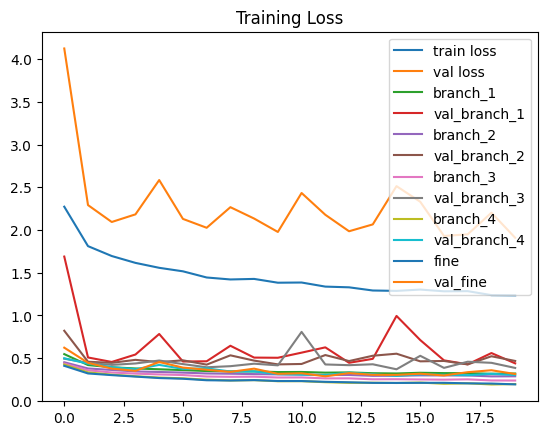

In [12]:
# loss
plt.title('Training Loss')
plt.plot(hist.history['loss'], label='train loss')
plt.plot(hist.history['val_loss'], label='val loss')
plt.plot(hist.history['branch_1_loss'], label='branch_1')
plt.plot(hist.history['val_branch_1_loss'], label='val_branch_1')
plt.plot(hist.history['branch_2_loss'], label='branch_2')
plt.plot(hist.history['val_branch_2_loss'], label='val_branch_2')
plt.plot(hist.history['branch_3_loss'], label='branch_3')
plt.plot(hist.history['val_branch_3_loss'], label='val_branch_3')
plt.plot(hist.history['branch_4_loss'], label='branch_4')
plt.plot(hist.history['val_branch_4_loss'], label='val_branch_4')
plt.plot(hist.history['fine_branch_loss'], label='fine')
plt.plot(hist.history['val_fine_branch_loss'], label='val_fine')
plt.legend()
plt.show()

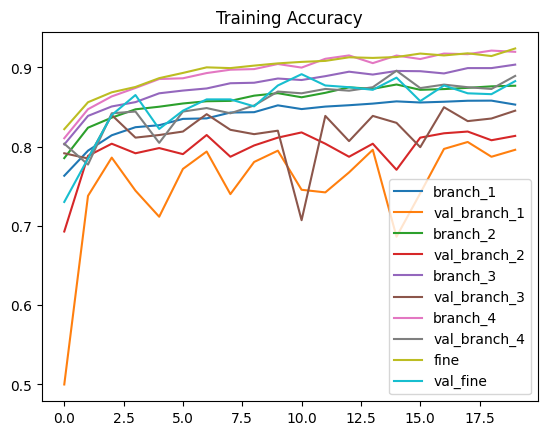

In [13]:
# for i in range(3,8):
#     plt.plot(hist.history['dense_'+str(i)+'_accuracy'], label='dense_'+str(i)+'_accuracy')
#     plt.plot(hist.history['val_dense_'+str(i)+'_accuracy'], label='val_dense_'+str(i)+'_accuracy')
# plt.legend()
# plt.show()

# accuracy
plt.title('Training Accuracy')
plt.plot(hist.history['branch_1_accuracy'], label='branch_1')
plt.plot(hist.history['val_branch_1_accuracy'], label='val_branch_1')
plt.plot(hist.history['branch_2_accuracy'], label='branch_2')
plt.plot(hist.history['val_branch_2_accuracy'], label='val_branch_2')
plt.plot(hist.history['branch_3_accuracy'], label='branch_3')
plt.plot(hist.history['val_branch_3_accuracy'], label='val_branch_3')
plt.plot(hist.history['branch_4_accuracy'], label='branch_4')
plt.plot(hist.history['val_branch_4_accuracy'], label='val_branch_4')
plt.plot(hist.history['fine_branch_accuracy'], label='fine')
plt.plot(hist.history['val_fine_branch_accuracy'], label='val_fine')
plt.legend()
plt.show()

In [14]:
score_test = model.evaluate(test_set)

1824/1824 [==============================] - 47s 25ms/step - loss: 1.7388 - branch_1_loss: 0.4438 - branch_2_loss: 0.4125 - branch_3_loss: 0.3334 - branch_4_loss: 0.2697 - fine_branch_loss: 0.2794 - branch_1_accuracy: 0.7950 - branch_2_accuracy: 0.8383 - branch_3_accuracy: 0.8624 - branch_4_accuracy: 0.8931 - fine_branch_accuracy: 0.8931


In [15]:
pred = model.predict(test_set)

# Get the number of unique labels
num_labels = len(np.unique(test_set.classes))

predicted_class_indices = []

for branch in range(5):
    predicted_class_indices.append(np.argmax(pred[branch],axis=1))

# Define a list of label names
label_names = ['Drowsy', 'Non_Drowsy']

# Compute the accuracy for each label
for branch in range(5):
    predicted_class = predicted_class_indices[branch]

    label_accs = {}
    for label in range(num_labels):
        idx = np.where(test_set.classes == label)[0]
        label_acc = np.mean(predicted_class[idx] == test_set.classes[idx])
        label_accs[label_names[label]] = label_acc

    # Print the accuracy for each label
    for label, acc in label_accs.items():
        print(f"Accuracy for label {label}: {acc:.2f}")
    print("\n")

Accuracy for label Drowsy: 0.91
Accuracy for label Non_Drowsy: 0.68


Accuracy for label Drowsy: 0.76
Accuracy for label Non_Drowsy: 0.92


Accuracy for label Drowsy: 0.83
Accuracy for label Non_Drowsy: 0.89


Accuracy for label Drowsy: 0.86
Accuracy for label Non_Drowsy: 0.92


Accuracy for label Drowsy: 0.88
Accuracy for label Non_Drowsy: 0.90




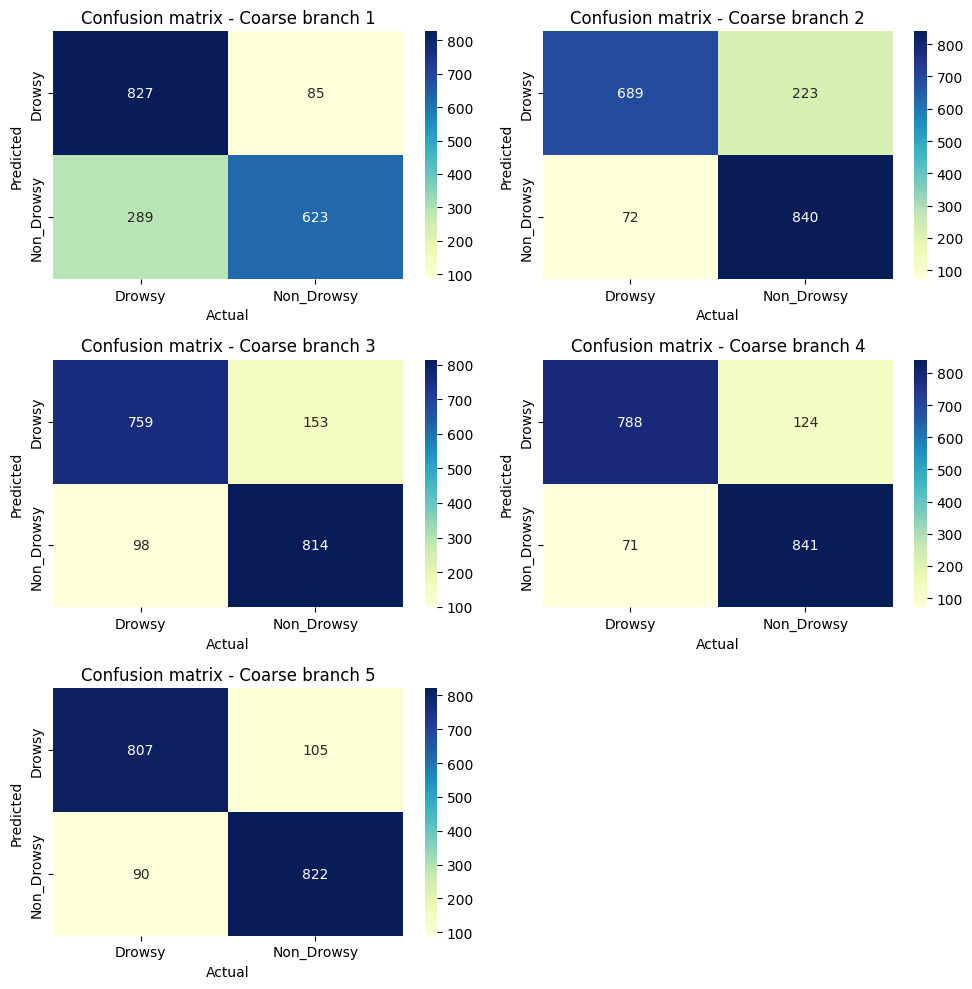

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

plt.figure(figsize=(10, 10))

# Get the true labels for the test set
y_true = test_set.classes

# Iterate over each branch
for branch in range(5):
    # Compute the confusion matrix for the current branch
    conf_mat = confusion_matrix(y_true, predicted_class_indices[branch])

    df_cm = pd.DataFrame(conf_mat, index=['Drowsy', 'Non_Drowsy'], 
                         columns=['Drowsy', 'Non_Drowsy'])

    # Create a subplot for the current branch
    plt.subplot(3, 2, branch+1)  # Adjust the subplot layout as needed
    plt.title("Confusion matrix - Coarse branch {}".format(branch+1))
    sns.heatmap(df_cm, annot=True, fmt="d", cmap="YlGnBu")
    plt.ylabel("Predicted")
    plt.xlabel("Actual")

# Adjust the spacing between subplots if necessary
plt.tight_layout()

# Show the plot
plt.show()


In [17]:
from sklearn.metrics import classification_report

for branch in range(5):
    # Assuming y_true and y_pred are the true and predicted labels
    report = classification_report(y_true, predicted_class_indices[branch])
    print(report)

              precision    recall  f1-score   support

           0       0.74      0.91      0.82       912
           1       0.88      0.68      0.77       912

    accuracy                           0.79      1824
   macro avg       0.81      0.79      0.79      1824
weighted avg       0.81      0.79      0.79      1824

              precision    recall  f1-score   support

           0       0.91      0.76      0.82       912
           1       0.79      0.92      0.85       912

    accuracy                           0.84      1824
   macro avg       0.85      0.84      0.84      1824
weighted avg       0.85      0.84      0.84      1824

              precision    recall  f1-score   support

           0       0.89      0.83      0.86       912
           1       0.84      0.89      0.87       912

    accuracy                           0.86      1824
   macro avg       0.86      0.86      0.86      1824
weighted avg       0.86      0.86      0.86      1824

              preci

## Saving the model

In [ ]:
# # Saving the model
# import tensorflow as tf

# from keras.models import load_model

# model.save('C:/Users/wweis/Deep Learning/SC6-Net/models/CE_SC6-Net.h5')

## Load the saved model

In [6]:
from keras.models import load_model

saved_model = load_model("models/CE_SC6-Net.h5")
# saved_model = load_model("models/FL_Drowsy.h5", custom_objects=custom_object)

In [7]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory('C:/SC6-Net/data/train',
                                                 target_size = (224, 224),
                                                 batch_size = 1,
                                                 class_mode = 'categorical',
                                                 shuffle=False,
                                                 seed=42)

validation_set = test_datagen.flow_from_directory('C:/SC6-Net/data/valid',
                                                  target_size=(224, 224),
                                                  batch_size=1,
                                                  class_mode='categorical',
                                                  shuffle=False,
                                                  seed=42)

test_set = test_datagen.flow_from_directory('C:/SC6-Net/data/test',
                                            target_size = (224, 224),
                                            batch_size=1,
                                            class_mode='categorical',
                                            shuffle=False,
                                            seed=42)

Found 6384 images belonging to 2 classes.
Found 912 images belonging to 2 classes.
Found 1824 images belonging to 2 classes.


In [8]:
branch_predictions_train = saved_model.predict(training_set)
branch_predictions_valid = saved_model.predict(validation_set)
branch_predictions_test = saved_model.predict(test_set)

In [9]:
indices_to_remove = [0]
best_train_branch = [arr for index, arr in enumerate(branch_predictions_train) if index not in indices_to_remove]
best_valid_branch = [arr for index, arr in enumerate(branch_predictions_valid) if index not in indices_to_remove]
best_test_branch = [arr for index, arr in enumerate(branch_predictions_test) if index not in indices_to_remove]

In [10]:
best_train_branch = np.array(best_train_branch)
best_valid_branch = np.array(best_valid_branch)
best_test_branch = np.array(best_test_branch)

In [11]:
features_train = []
for i in range(len(best_train_branch)):
    probs = best_train_branch[i]
    features_train.append(probs)

features_valid = []
for i in range(len(best_train_branch)):
    probs = best_valid_branch[i]
    features_valid.append(probs)

features_test = []
for i in range(len(best_train_branch)):
    probs = best_test_branch[i]
    features_test.append(probs)
    
features_train = np.array(features_train)
features_valid = np.array(features_valid)
features_test = np.array(features_test)

In [13]:
len(best_train_branch)

4

In [14]:
probs_train = []
for i in range(len(training_set)):
    probs_values = []
    for j in range(len(best_train_branch)):
        prob = features_train[j, i]
        probs_values.append(prob)
    probs_concatenated = np.concatenate(probs_values, axis=0)
    probs_train.append(probs_concatenated)
    
probs_valid = []
for i in range(len(validation_set)):
    probs_values = []
    for j in range(len(best_train_branch)):
        prob = features_valid[j, i]
        probs_values.append(prob)
    probs_concatenated = np.concatenate(probs_values, axis=0)
    probs_valid.append(probs_concatenated)
    
probs_test = []
for i in range(len(test_set)):
    probs_values = []
    for j in range(len(best_train_branch)):
        prob = features_test[j, i]
        probs_values.append(prob)
    probs_concatenated = np.concatenate(probs_values, axis=0)
    probs_test.append(probs_concatenated)
    
probs_train = np.array(probs_train)
probs_valid = np.array(probs_valid)
probs_test = np.array(probs_test)

In [15]:
from keras.utils import np_utils
# one hot encode outputs
y_train = np_utils.to_categorical(training_set.labels, num_classes=len(folders))
y_valid = np_utils.to_categorical(validation_set.labels, num_classes=len(folders))
y_test = np_utils.to_categorical(test_set.labels, num_classes=len(folders))

In [16]:
# Step 7: Train the multilayer perceptron using the probability features
mlp = Sequential()
mlp.add(Dense(512, activation='relu', input_shape=(8,)))
mlp.add(Flatten())
mlp.add(Dense(512, activation='relu'))
mlp.add(Dense(256, activation='relu'))
mlp.add(Dense(128, activation='relu'))
mlp.add(Dense(64, activation='relu'))
mlp.add(Dense(len(folders), activation='softmax'))

In [17]:
mlp.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               4608      
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 1

In [18]:
# Compile and train the MLP
mlp.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# mlp.compile(optimizer='adam', loss=categorical_focal_loss(0.25), metrics=['accuracy'])
hist1 = mlp.fit(probs_train, y_train, validation_data=(probs_valid, y_valid), batch_size=32, epochs=20)

Epoch 1/20
200/200 [==============================] - 1s 5ms/step - loss: 0.1939 - accuracy: 0.9320 - val_loss: 0.2937 - val_accuracy: 0.8925
Epoch 2/20
200/200 [==============================] - 1s 5ms/step - loss: 0.1693 - accuracy: 0.9369 - val_loss: 0.3064 - val_accuracy: 0.8882
Epoch 3/20
200/200 [==============================] - 1s 5ms/step - loss: 0.1673 - accuracy: 0.9388 - val_loss: 0.3432 - val_accuracy: 0.8849
Epoch 4/20
200/200 [==============================] - 1s 4ms/step - loss: 0.1636 - accuracy: 0.9381 - val_loss: 0.3441 - val_accuracy: 0.8904
Epoch 5/20
200/200 [==============================] - 1s 5ms/step - loss: 0.1594 - accuracy: 0.9392 - val_loss: 0.3344 - val_accuracy: 0.8816
Epoch 6/20
200/200 [==============================] - 1s 6ms/step - loss: 0.1613 - accuracy: 0.9389 - val_loss: 0.3523 - val_accuracy: 0.8816
Epoch 7/20
200/200 [==============================] - 1s 6ms/step - loss: 0.1600 - accuracy: 0.9392 - val_loss: 0.2846 - val_accuracy: 0.8914
Epoch 

In [19]:
score_mlp = mlp.evaluate(probs_test, y_test)

57/57 [==============================] - 0s 3ms/step - loss: 0.2597 - accuracy: 0.8986


In [20]:
from sklearn.metrics import classification_report

predicted = mlp.predict(probs_test)

In [21]:
y_pred_label = np.argmax(predicted, axis=1)

In [22]:
report = classification_report(test_set.labels, y_pred_label)
print(report)

              precision    recall  f1-score   support

           0       0.91      0.88      0.90       912
           1       0.88      0.92      0.90       912

    accuracy                           0.90      1824
   macro avg       0.90      0.90      0.90      1824
weighted avg       0.90      0.90      0.90      1824



In [23]:
# Saving the model

# mlp.save('C:/Users/wweis/Deep Learning/SC6-Net/models/MLP_CE_SC6-Net.h5')